# SCP 

In [10]:
plt.rcParams.update({'font.size': 25})
plt.style.use("dark_background")

In [1]:
# packages
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
import csv

In [3]:
# constant
c = 2.99792458 * 1e5 # units: km/s

In [11]:
# read redshift and luminosity distance data from file
data_scp = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
data = data_scp
with open('SCPUnion2.1_mu_vs_z.txt') as f:
    reader = csv.reader(f, delimiter="\t")
    d = list(reader)

redshift = data_scp.T[1]
dist_mod = data_scp.T[2] #pc
dist_mod_err = data_scp.T[3] #pc
lum_dist = 10**((dist_mod - 25)/5)
lum_dist_err = lum_dist * np.log(10) * dist_mod_err/5

In [12]:
def D_L(z, omega_m, omega_lambda, H_0):
    omega_k = 1-omega_m-omega_lambda
    if (omega_k == 0): # handle this case separately to avoid division by zero errors
        def integrand(x):
            return 1/np.sqrt((1+x)**2*(1+omega_m*x) - x*(2+x)*omega_lambda)
        integral = integrate.quad(integrand,0,z)[0]
        r = c*integral/H_0
        return (1+z)*r
        
    prefactor = (c/H_0) * (1+z) * (1/np.sqrt(np.abs(omega_k)))
    def integrand(x):
        return 1/np.sqrt((1+x)**2 * (1+omega_m*x) - x * (2+x) * omega_lambda)
    integral = integrate.quad(integrand,0,z)[0]
    arg = np.sqrt(np.abs(omega_k)) * integral
    sinn = np.sin(arg) if omega_k <= 0 else np.sinh(arg)
    return prefactor * sinn

## Fitting Model to Data
To solve for the cosmological parameters, we will fit our luminosity distance and redshift data to the function ``D_L()`` using SciPy's curve_fit function.

In [13]:
def D_L_helper(redshifts, omega_m, omega_lambda, H_0):
    return [D_L(z,omega_m,omega_lambda,H_0) for z in redshifts]

In [14]:
bnds = ((0,0,60),(2,2,80))
popt, pcov = opt.curve_fit(D_L_helper, redshift, lum_dist, p0=[0.3,0.7,70], bounds = bnds, sigma = lum_dist_err)
omega_m, omega_lambda, H_0 = popt
omega_m_err, omega_lambda_err, H_0_err = np.sqrt(np.diag(pcov))

In [15]:
print("Matter density: ", "{0:.3f}".format(omega_m), " ± ", "{0:.3f}".format(omega_m_err))
print("Dark energy density: ", "{0:.2f}".format(omega_lambda), " ± ", "{0:.2f}".format(omega_lambda_err))
print("Hubble constant: ", "{0:.2f}".format(H_0), " ± ", "{0:.2f}".format(H_0_err))

Matter density:  0.323  ±  0.069
Dark energy density:  0.75  ±  0.11
Hubble constant:  70.49  ±  0.43


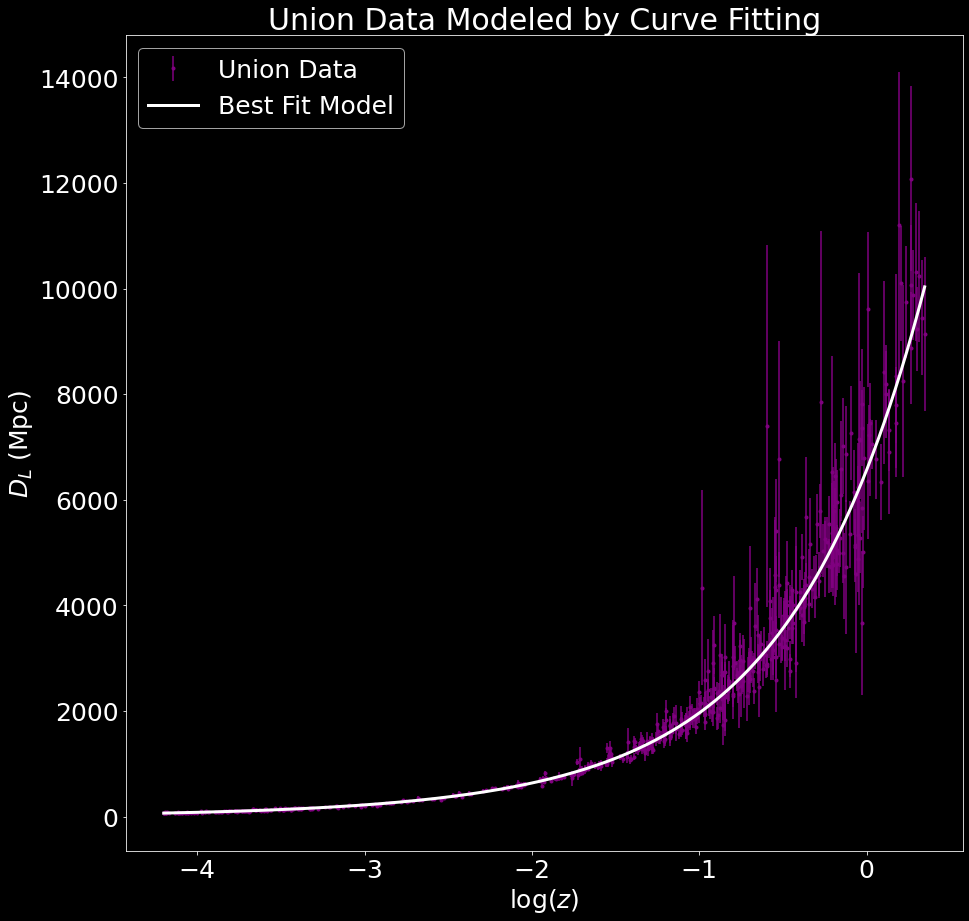

In [16]:
plt.figure(figsize = (15,15))
zz = np.linspace(np.min(redshift),np.max(redshift),1000)
plt.errorbar(np.log(redshift),lum_dist,yerr=lum_dist_err,fmt='.',color='purple')
plt.errorbar(np.log(zz),D_L_helper(zz, omega_m, omega_lambda, H_0), linewidth=3,color='white')
plt.xlabel("$\log(z)$")
plt.ylabel("$D_L$ (Mpc)")
plt.legend(("Union Data","Best Fit Model"),loc='upper left')
plt.title("Luminosity Distance vs. Redshift (SCP Data)");

## Phase Space Sampling


In [18]:
num_points = 20

omega_m_range = np.linspace(0,1.5,num_points)
omega_lambda_range = np.linspace(0,1.5,num_points)

H_0_range = np.linspace(60,80,num_points)

omega_m_best = omega_m_range[0]
omega_lambda_best = omega_lambda_range[0]
H_0_best = H_0_range[0]
expected = D_L_helper(redshift, omega_m, omega_lambda, H_0)
chi2_best = np.sum((lum_dist - expected)**2/lum_dist_err**2)
k_best = 0


chi2_arr = np.zeros((num_points,num_points,num_points))
new_array = np.zeros((num_points,num_points))

for k in np.arange(np.size(H_0_range)):
    for i in np.arange(np.size(omega_m_range)):
        for j in np.arange(np.size(omega_lambda_range)):
                omega_m = omega_m_range[i]
                omega_lambda = omega_lambda_range[j]
                H_0 = H_0_range[k]
                expected = D_L_helper(redshift, omega_m, omega_lambda, H_0)
                chi2 = np.sum((lum_dist - expected)**2/lum_dist_err**2)
                chi2_arr[i][j][k] = chi2
                new_array[i][j] = chi2
                if chi2 < chi2_best:
                    omega_m_best = omega_m
                    omega_lambda_best = omega_lambda
                    H_0_best = H_0
                    chi2_best = chi2
                    k_best = k

print("Matter density: ", "{0:.2f}".format(omega_m_best))
print("Dark energy density: ", "{0:.2f}".format(omega_lambda_best))
print("Hubble constant: ", "{0:.2f}".format(H_0_best))

<ipython-input-12-f655e3600710>:12: RuntimeWarning: invalid value encountered in sqrt
  return 1/np.sqrt((1+x)**2 * (1+omega_m*x) - x * (2+x) * omega_lambda)
<ipython-input-12-f655e3600710>:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = integrate.quad(integrand,0,z)[0]


Matter density:  0.32
Dark energy density:  0.71
Hubble constant:  70.53


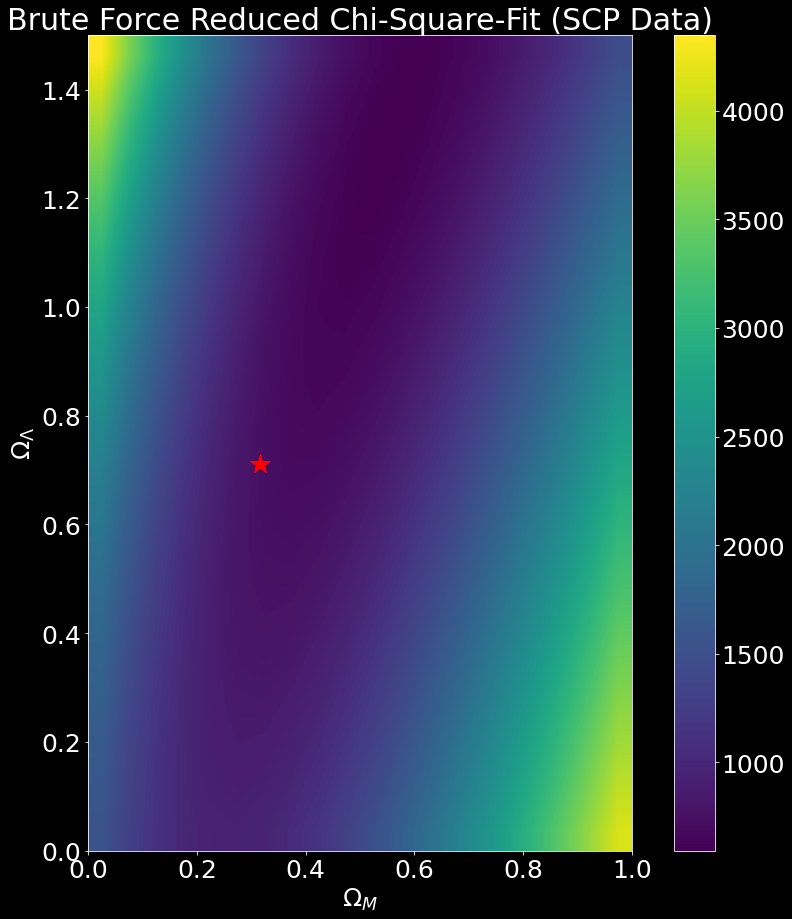

In [19]:
chi2_slice = chi2_arr[:][:][k_best]
plt.figure(figsize = (15,15))
im = plt.imshow(chi2_slice, interpolation='bilinear', origin='lower', \
                cmap='viridis', extent=(0.,1.0,0.,1.5))
plt.colorbar()
#plt.plot(X[am],Y[am],'r*',markersize=20)
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Brute Force Reduced Chi-Square-Fit (SCP Data)')
plt.plot(omega_m_best,omega_lambda_best,'r*',markersize=20)
plt.show()


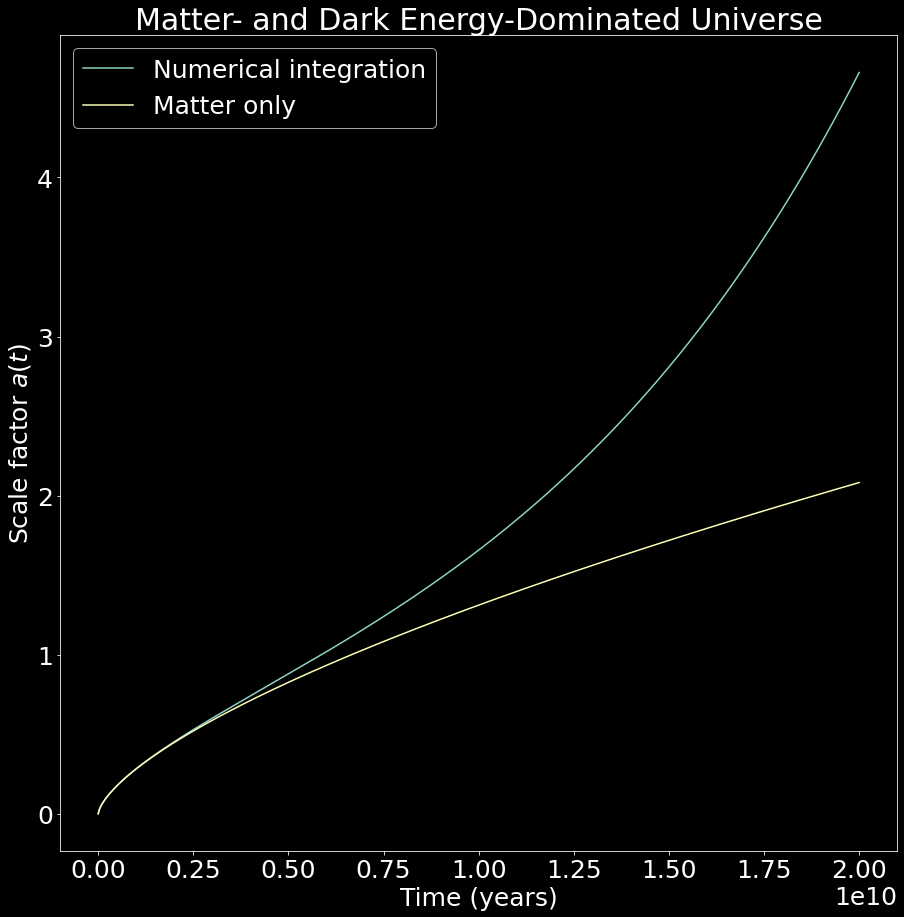

In [20]:
t_range = 0,20e9 # in units of t0
a0 = np.array([1e-15]) # pick some small but nonzero value
H_0_yrs = H_0 / 3.086e19 * 3.154e7 # convert H_0 to units of 1/years
adot = lambda time, a: H_0_yrs * np.sqrt(omega_m/a + omega_lambda * a**2)
rel_err_tolerance = 1e-5
t_eval = np.linspace(0,20e9,1000)

soln = integrate.solve_ivp(adot, t_range, a0, rtol=rel_err_tolerance, t_eval=t_eval)
times = soln.t
states = soln.y

exp = (3/2 * H_0_yrs * np.sqrt(omega_m) * times)**(2/3)
plt.figure(figsize = (15,15))

plt.plot(times, states[0], label='Numerical integration')
plt.plot(times, exp, label='Matter only')
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.title("Matter- and Dark Energy-Dominated Universe")
plt.legend();

In [21]:
def a(t,omega_m,omega_lambda,H_0):
    num = omega_m**(1/3) * np.tanh(3/2 * H_0 * np.sqrt(omega_lambda) * t)**(2/3)
    den = (omega_lambda - omega_lambda * np.tanh(3/2 * H_0 * np.sqrt(omega_lambda) * t)**2)**(1/3)
    if den == 0:
        return 0
    return num/den

In [22]:
def a_helper(times,omega_m,omega_lambda,H_0):
    return [a(t,omega_m,omega_lambda,H_0) for t in times]


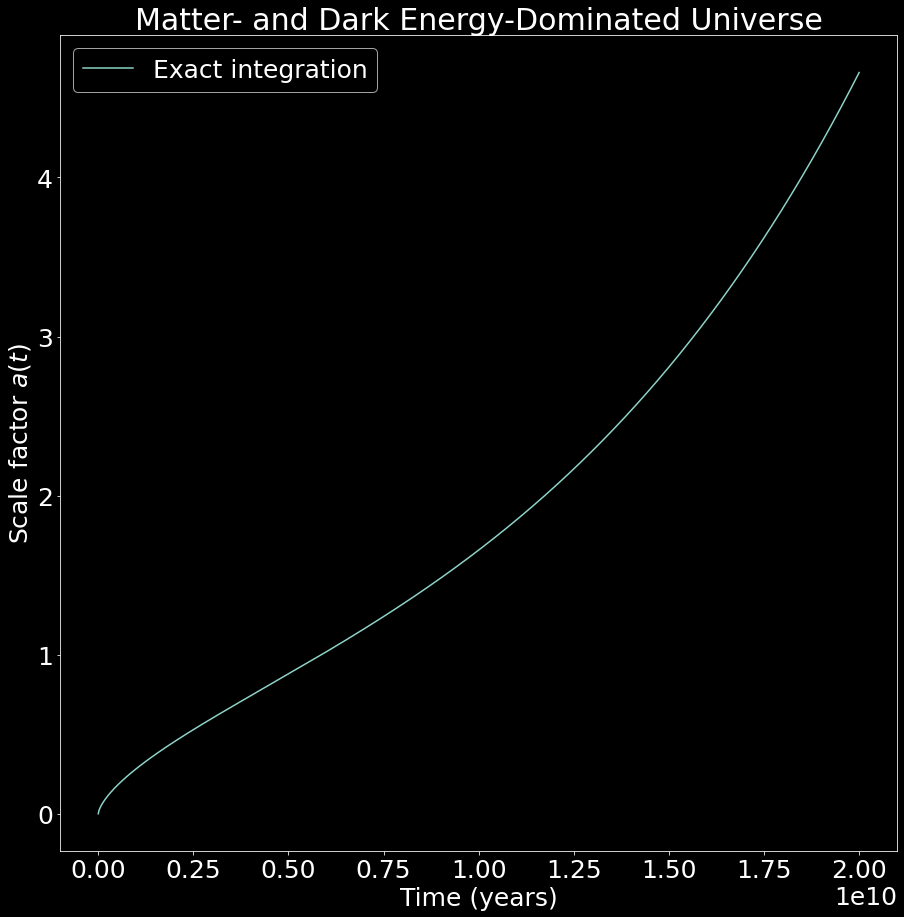

In [23]:
plt.figure(figsize = (15,15))

plt.plot(times, a_helper(times,omega_m,omega_lambda,H_0_yrs),label='Exact integration')
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.title("Matter- and Dark Energy-Dominated Universe")
plt.legend();

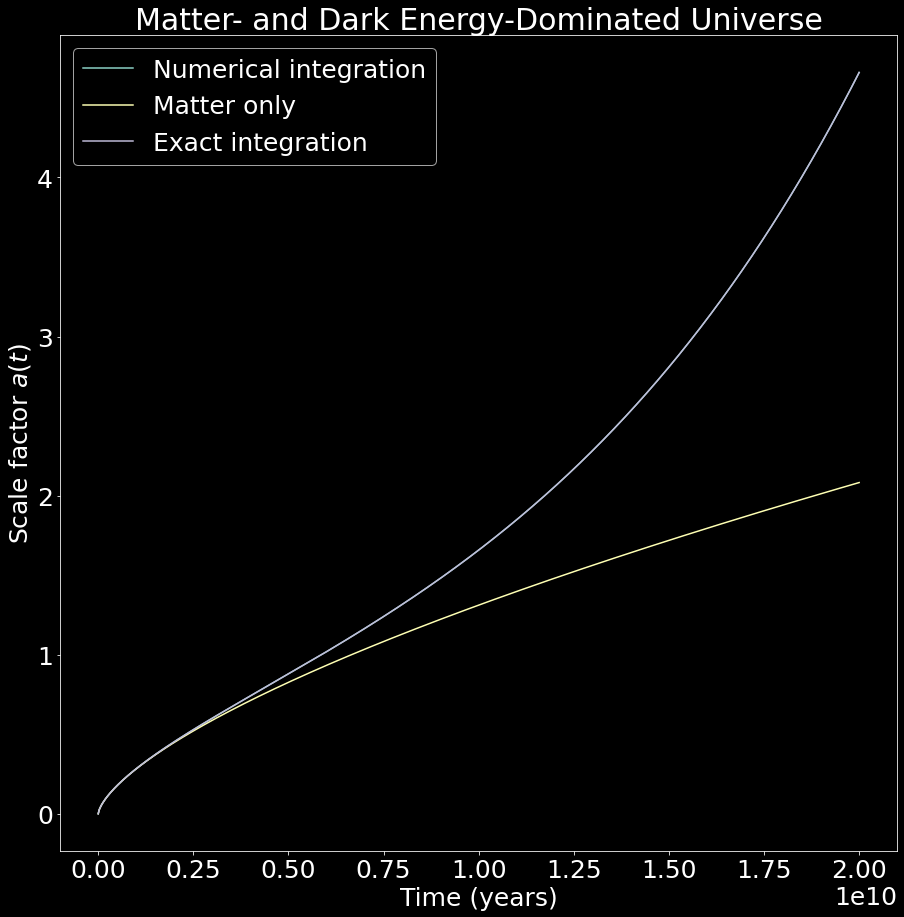

In [24]:
soln = integrate.solve_ivp(adot, t_range, a0, rtol=rel_err_tolerance, t_eval=t_eval)
times = soln.t
states = soln.y

exp = (3/2 * H_0_yrs * np.sqrt(omega_m) * times)**(2/3)
plt.figure(figsize = (15,15))

plt.plot(times, states[0], label='Numerical integration')
plt.plot(times, exp, label='Matter only')
plt.plot(times, a_helper(times,omega_m,omega_lambda,H_0_yrs),label='Exact integration')
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.title("Matter- and Dark Energy-Dominated Universe")
plt.legend();

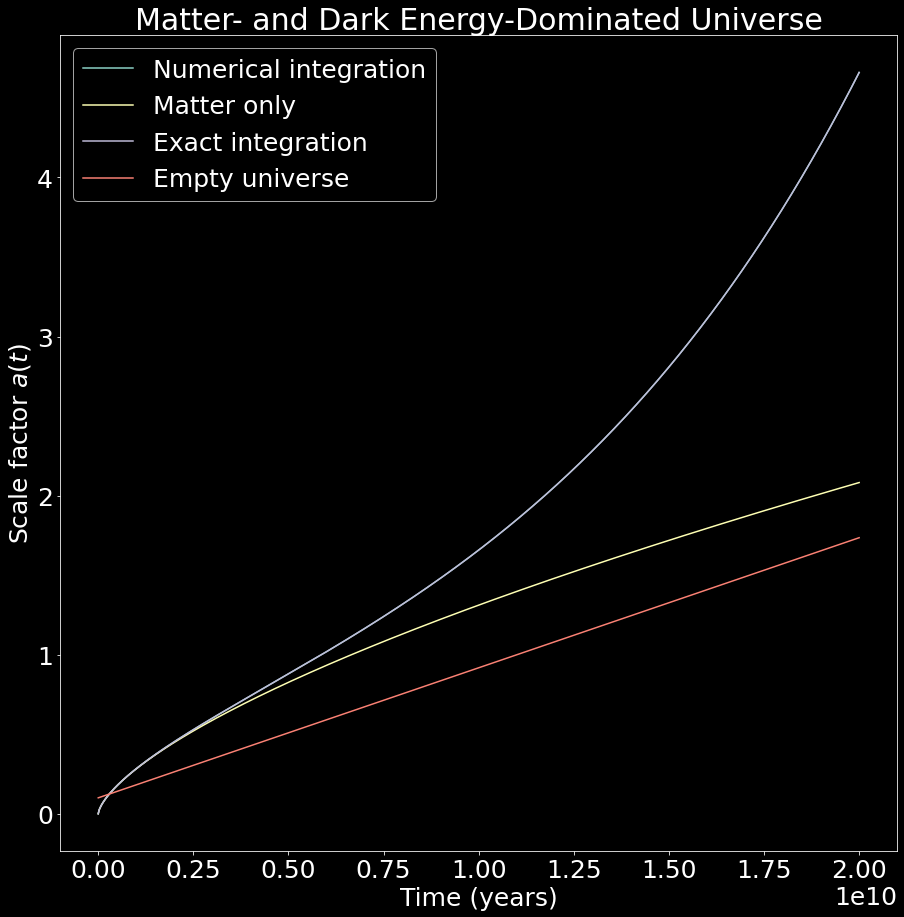

In [25]:
soln = integrate.solve_ivp(adot, t_range, a0, rtol=rel_err_tolerance, t_eval=t_eval)
times = soln.t
states = soln.y

exp = (3/2 * H_0_yrs * np.sqrt(omega_m) * times)**(2/3)

empty = H_0_yrs * times + 0.1
plt.figure(figsize = (15,15))

plt.plot(times, states[0], label='Numerical integration')
plt.plot(times, exp, label='Matter only')
plt.plot(times, a_helper(times,omega_m,omega_lambda,H_0_yrs),label='Exact integration')
plt.plot(times, empty, label='Empty universe')
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.title("Matter- and Dark Energy-Dominated Universe")
plt.legend();

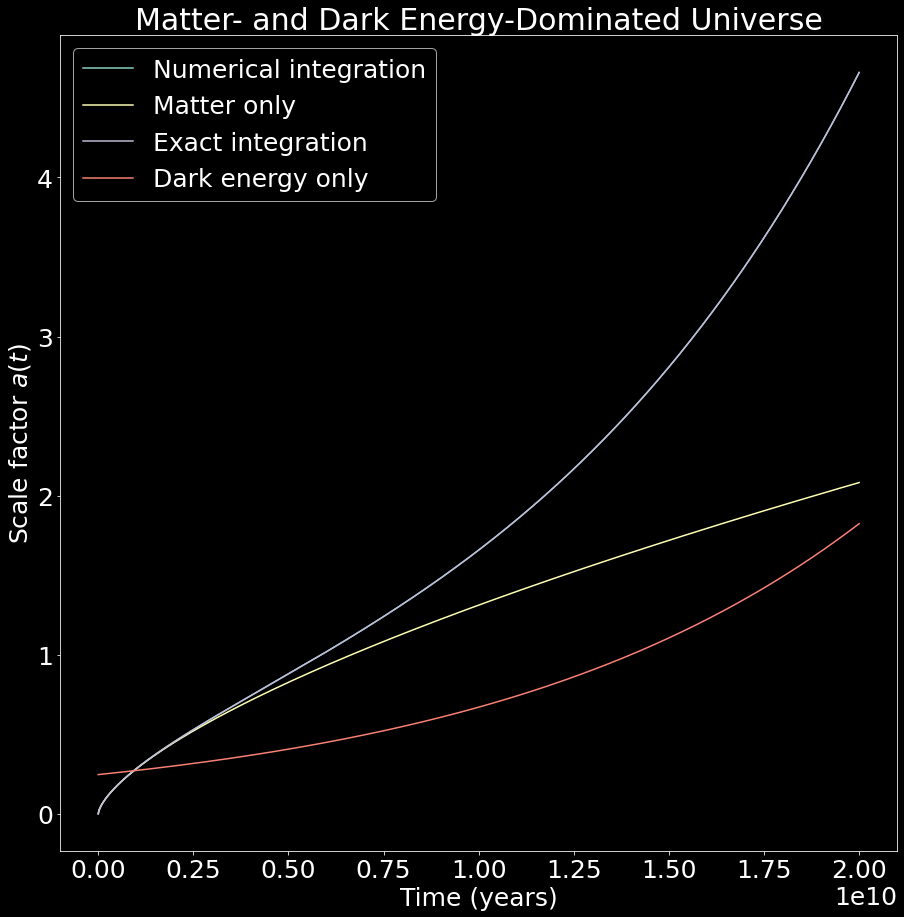

In [26]:
a0 = np.array([1e-15]) # pick some small but nonzero value
const = np.exp(-H_0_yrs * np.sqrt(omega_lambda) * 14 * 10**9)
soln = integrate.solve_ivp(adot, t_range, a0, rtol=rel_err_tolerance, t_eval=t_eval)
times = soln.t
states = soln.y

exp = (3/2 * H_0_yrs * np.sqrt(omega_m) * times)**(2/3)

de = np.exp(H_0_yrs * np.sqrt(omega_lambda) * (times-14*1e9))
plt.figure(figsize = (15,15))

plt.plot(times, states[0], label='Numerical integration')
plt.plot(times, exp, label='Matter only')
plt.plot(times, a_helper(times,omega_m,omega_lambda,H_0_yrs),label='Exact integration')
plt.plot(times, de, label='Dark energy only')
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.title("Matter- and Dark Energy-Dominated Universe")
plt.legend();

In [27]:
from astropy.cosmology import FlatLambdaCDM as magic

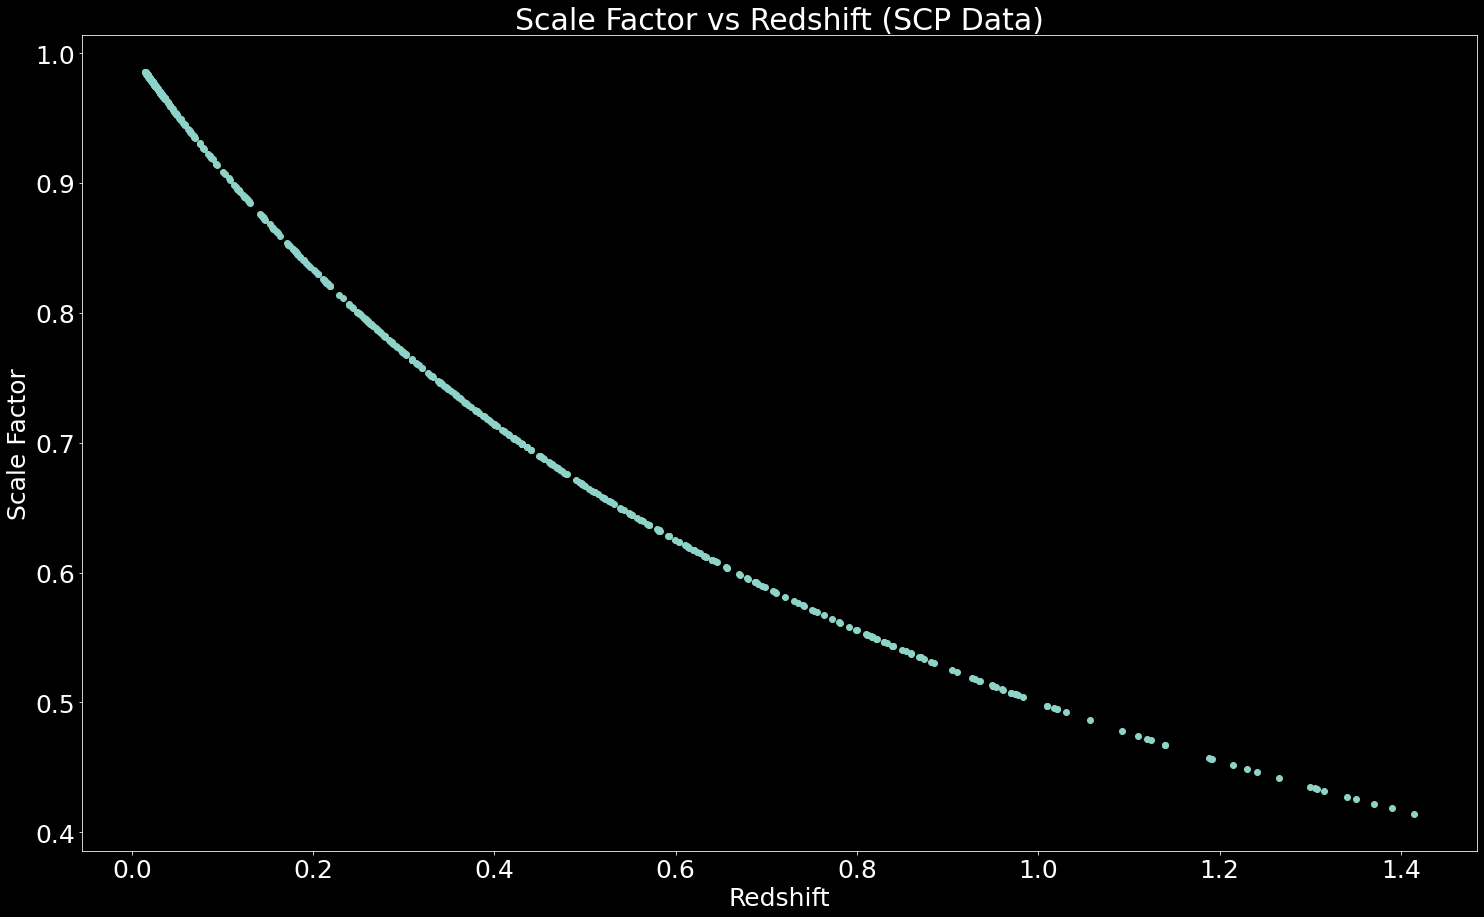

In [28]:
cosmo = magic(H0=H_0_best, Om0=omega_m_best)
plt.figure(figsize = (25,15))
scale_factor = cosmo.scale_factor(redshift)
plt.scatter(redshift, scale_factor)
plt.xlabel('Redshift')
plt.ylabel('Scale Factor')
plt.title('Scale Factor vs Redshift (SCP Data)')
plt.show()

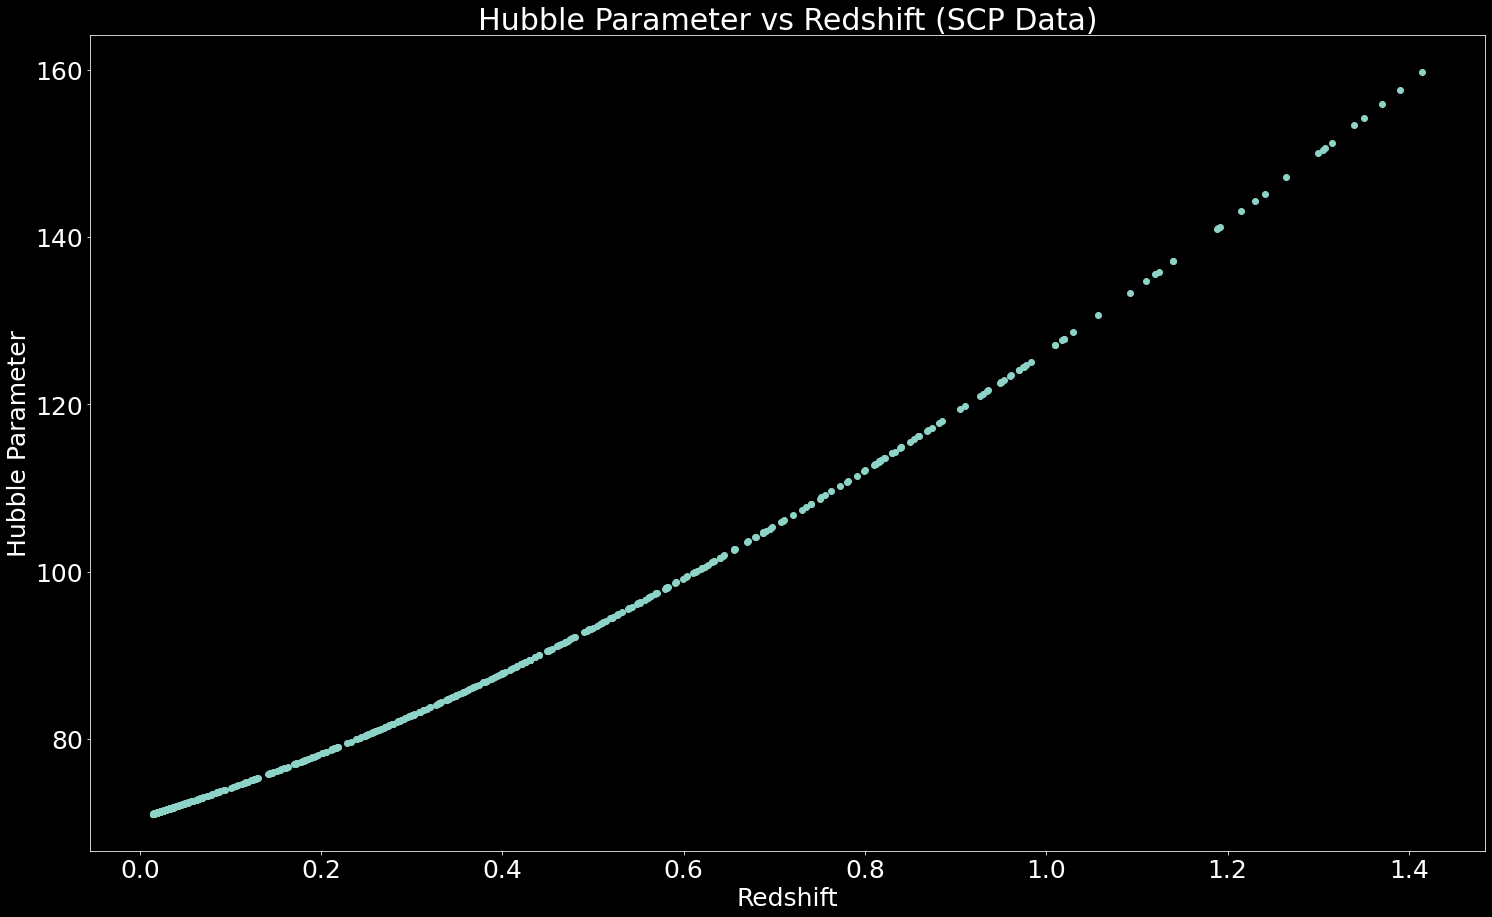

In [29]:
plt.figure(figsize = (25,15))
h = cosmo.H(redshift)
plt.scatter(redshift, h)
plt.xlabel('Redshift')
plt.ylabel('Hubble Parameter')
plt.title('Hubble Parameter vs Redshift (SCP Data)')
plt.show()

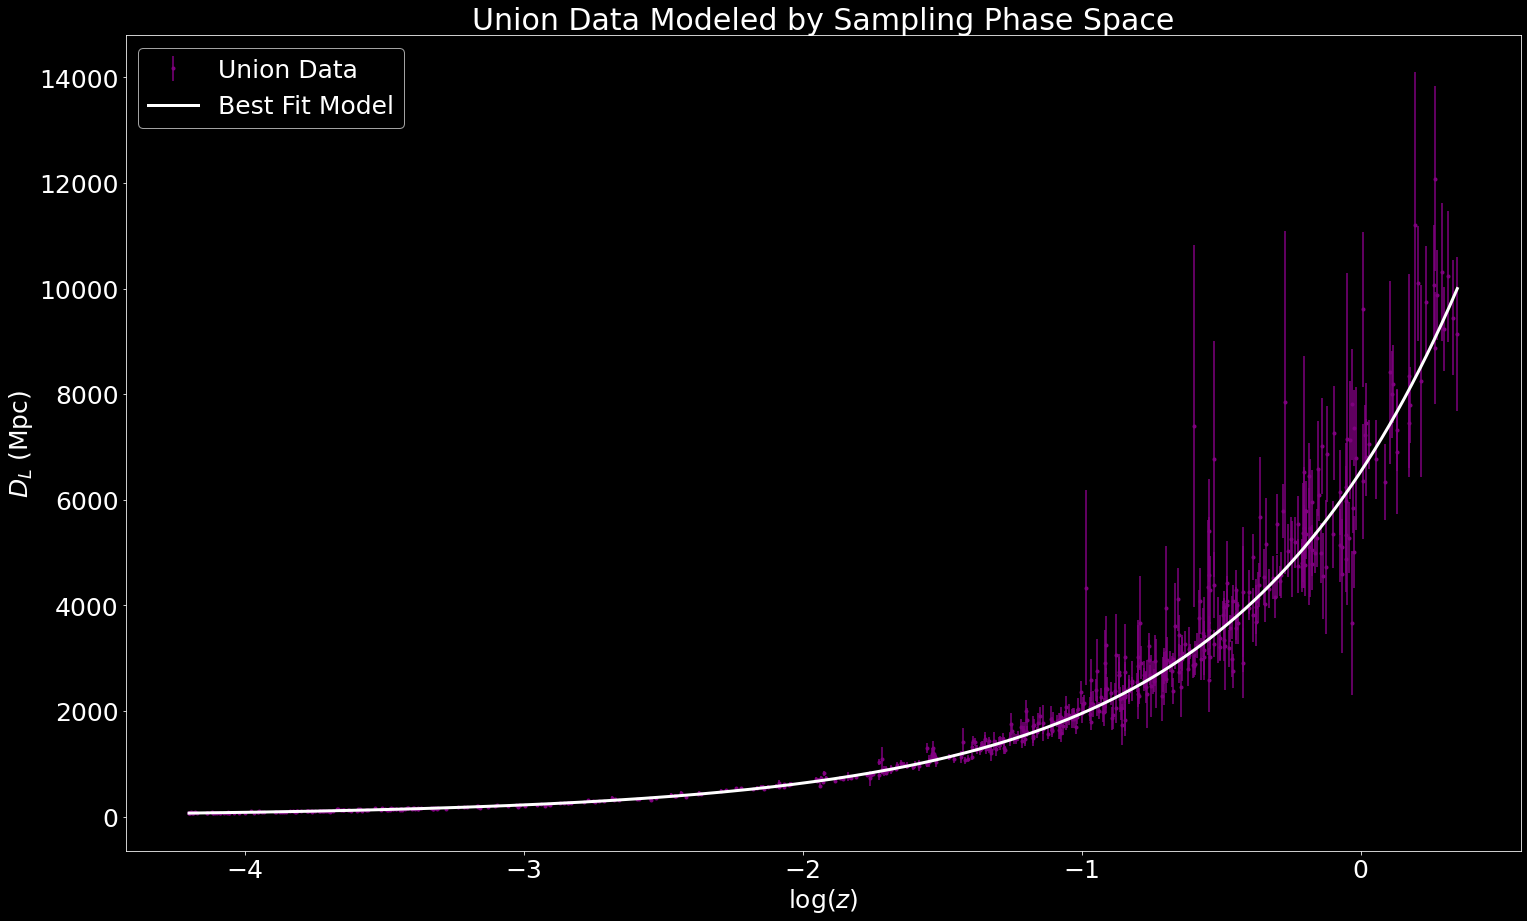

In [30]:
plt.figure(figsize = (25,15))
zz = np.linspace(np.min(redshift),np.max(redshift),1000)
plt.errorbar(np.log(redshift),lum_dist,yerr=lum_dist_err,fmt='.',color='purple')
plt.errorbar(np.log(zz),D_L_helper(zz, omega_m_best, omega_lambda_best, H_0_best), linewidth=3,color='white')
plt.xlabel("$\log(z)$")
plt.ylabel("$D_L$ (Mpc)")
plt.legend(("Union Data","Best Fit Model"),loc='upper left')
plt.title("Union Data Modeled by Sampling Phase Space");

## Scale Factor Integration

## Discussion of Results

## References
Ryden, B. Introduction to Cosmology. Addison Wesley, 2003.

Riess, A. G., et al. 1998, Astron. J., 116, 1009.